### Load Features

In [2]:
# load dataset
import pandas as pd
ham_users_input = pd.read_csv('data/ham_features.csv')
spam_users_input = pd.read_csv('data/spam_features.csv')

### Data Preparation

In [3]:
# add labels
ham_users_input['label'] = 0 
spam_users_input['label'] = 1

In [4]:
# combine dataframes
df = pd.concat([ham_users_input,spam_users_input])
# drop userID
df.drop(['UserID'], axis=1, inplace=True)

In [5]:
# separate features from labels
X = df.drop('label', axis = 1)
y = df['label']

In [6]:
# split train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

### Training Classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# train RF
clf = RandomForestClassifier(random_state=23, n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=23)

### Evaluating Classifer

In [8]:
# predict on test set
y_pred = clf.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.5f}')
f1 = f1_score(y_test, y_pred)
print(f'F1-Score: {f1:.5f}')

Accuracy: 0.96036
F1-Score: 0.96340


In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

Text(24.0, 0.5, 'True')

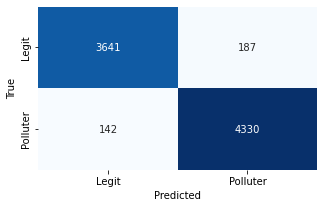

In [17]:
import seaborn as sn
import matplotlib.pyplot as plt
classes = ["Legit","Polluter"]
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')